# DATA

In [1]:
import numpy as np
import pandas as pd
import sklearn
import os
import pickle
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from scipy.stats import norm


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  
tf.random.set_seed(1234)

In [2]:
data = pd.read_csv('data/final_data.csv')
data.head()

,r,sigma,T,s0,k,t,asset,call,asset_greater_call,scaled_call,scaled_asset,tau,moneyness,d1,d2,delta,gamma,theta,vega,rho
0,0.05,0.05,0.1,10.0,10.0,0.0,10.000000,0.090978,True,0.009098,1.0,0.10,1.000000,0.324133,0.308322,0.627082,2.394010,-0.608243,1.197005,0.617984
1,0.05,0.05,0.1,10.0,10.0,1.0,9.977024,0.071240,True,0.007124,1.0,0.09,0.997702,0.154153,0.139153,0.561255,2.634254,-0.604191,1.179973,0.497558
2,0.05,0.05,0.1,10.0,10.0,2.0,9.979236,0.066344,True,0.006634,1.0,0.08,0.997924,0.142939,0.128797,0.556831,2.798086,-0.622830,1.114591,0.439232
3,0.05,0.05,0.1,10.0,10.0,3.0,10.085137,0.133263,True,0.013326,1.0,0.07,1.008514,0.912040,0.898811,0.819126,1.972797,-0.657203,0.702286,0.568942
4,0.05,0.05,0.1,10.0,10.0,4.0,9.964273,0.045868,True,0.004587,1.0,0.06,0.996427,-0.041160,-0.053407,0.483584,3.266261,-0.644005,0.972889,0.286362


In [3]:
scaler = StandardScaler()
X = data[['r','sigma','tau','k','asset']]
y = data['call']
#X = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1234)

# NEURAL NET MODEL

In [4]:
from keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Embedding, LSTM, Dense, BatchNormalization, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow.keras.initializers import RandomUniform, GlorotUniform, HeUniform
from keras.models import model_from_json
from keras import backend as K
import tensorflow_addons as tfa
from tensorflow import GradientTape

In [5]:
def create_model(activation, lr_0, batch_norm, dropout_rate, layer_number, neuron_number,\
                neuron_decrease, data_length, initializer):
    opt = Adam(learning_rate = lr_0)
    model = Sequential()
    model.add(Dense(neuron_number, input_shape=(5,), activation = activation, \
                    kernel_initializer=initializer , bias_initializer=initializer))
    for i in range(layer_number):
        if batch_norm == True:
            model.add(BatchNormalization())         
        neuron_number = int(neuron_number/neuron_decrease)
        model.add(Dense(neuron_number, activation = activation))
    if batch_norm == True:
        model.add(BatchNormalization()) 
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, name='Final_1D_output', activation = activation))
    model.compile(optimizer=opt,loss='mean_squared_error',\
                  metrics=[tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))],\
                 run_eagerly=True)
    print(model.summary())
    return model

def callback_list(patience):
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    return early_stop

def plot_loss(loss,val_loss):    
    plt.figure()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
   # plt.ylim((0,0.1))
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

def plot_metr(metr,val_metr,name):
    plt.figure()
    plt.plot(metr)
    plt.plot(val_metr)
    plt.title('Model'+str(name))
    plt.ylabel(str(name))
    plt.xlabel('Epoch')
  #  plt.ylim((0,1))
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show() 

In [6]:
patience_f = 10
callbacks = callback_list(patience=patience_f)

# TOTALLY TUNED MODEL

## Result from GridSearch

In [7]:
# load json and create model
json_file_hyper = open('results/grid_results_greeks/model_extra_greeks.json', 'r')
model_hyper = json_file_hyper.read()
json_file_hyper.close()
final_model = model_from_json(model_hyper)
# load weights into new model
final_model.load_weights("results/grid_results_greeks/model_extra_greeks.h5")
print("Loaded model from disk")

Metal device set to: Apple M1 Pro
Loaded model from disk


In [9]:
final_hist = pd.read_csv('results/grid_results_greeks/train_hist_extra_greeks.csv')
#train_hist = train_hist[:(train_hist.shape[0])-patience]
final_hist

,loss,r_square,val_loss,val_r_square
0,2.483879,0.947328,5.077482,0.893907
1,0.433023,0.990818,0.403818,0.991562
2,0.248943,0.994721,0.131855,0.997245
3,0.213849,0.995465,0.102957,0.997849
4,0.167967,0.996438,0.075145,0.998430
5,0.165600,0.996488,1.179124,0.975362
6,0.138229,0.997069,0.071791,0.998500
7,0.133869,0.997161,0.082975,0.998266
8,0.114059,0.997581,0.115785,0.997581


In [11]:
# HYPERPARAMETER TUNING
a_file = open("results/grid_results_greeks/search_params_extra_greeks.pkl", "rb")
output = pickle.load(a_file)
print(output)
a_file.close()

{'activation': 'relu', 'batch_norm': True, 'batch_size': 2048, 'data_length': 1000000, 'dropout_rate': 0.0, 'initializer': <keras.initializers.initializers_v2.RandomUniform object at 0x107001910>, 'layer_number': 3, 'lr_0': 0.001, 'neuron_decrease': 2, 'neuron_number': 512}


In [12]:
final_model_arch = create_model(activation = output['activation'], lr_0 = output['lr_0'], \
                                 batch_norm = output['batch_norm'], dropout_rate = output['dropout_rate'], \
                                 layer_number = output['layer_number'], neuron_number = output['neuron_number'], \
                                    data_length = output['data_length'], neuron_decrease = output['neuron_decrease'],\
                                 initializer = output['initializer'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               3072      
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_2 (Batc  (None, 128)              5

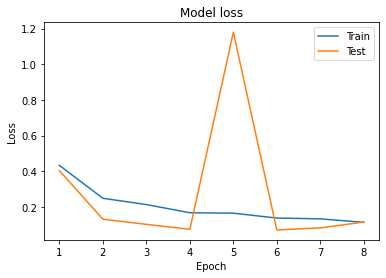

In [13]:
plot_loss(final_hist['loss'][1:], final_hist['val_loss'][1:])

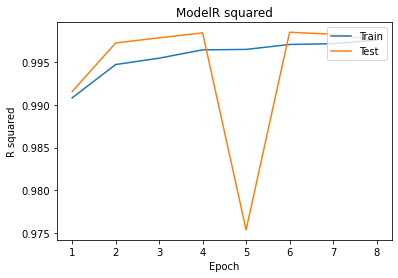

In [14]:
plot_metr(final_hist['r_square'][1:], \
          final_hist['val_r_square'][1:], 'R squared')

## Last fit with 200 epochs

In [15]:
trained_200 = final_model_arch.fit(X_train,y_train,epochs=200,validation_split=0.2,callbacks=[callbacks],
                           batch_size = output['batch_size'])

Epoch 1/200


2022-05-08 11:55:04.444631: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


313/313 [==============================] - 11s 32ms/step - loss: 2.9275 - r_square: 0.9379 - val_loss: 5.4875 - val_r_square: 0.8853
Epoch 2/200
313/313 [==============================] - 10s 32ms/step - loss: 0.4859 - r_square: 0.9897 - val_loss: 1.1680 - val_r_square: 0.9756
Epoch 3/200
313/313 [==============================] - 10s 31ms/step - loss: 0.2965 - r_square: 0.9937 - val_loss: 0.3092 - val_r_square: 0.9935
Epoch 4/200
313/313 [==============================] - 10s 31ms/step - loss: 0.2192 - r_square: 0.9954 - val_loss: 0.3871 - val_r_square: 0.9919
Epoch 5/200
313/313 [==============================] - 10s 32ms/step - loss: 0.1767 - r_square: 0.9963 - val_loss: 0.0434 - val_r_square: 0.9991
Epoch 6/200
313/313 [==============================] - 10s 32ms/step - loss: 0.1708 - r_square: 0.9964 - val_loss: 0.5762 - val_r_square: 0.9880
Epoch 7/200
313/313 [==============================] - 10s 32ms/step - loss: 0.1419 - r_square: 0.9970 - val_loss: 0.0499 - val_r_square: 0.99

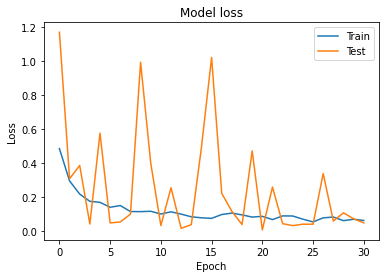

In [16]:
plot_loss(trained_200.history['loss'][1:], trained_200.history['val_loss'][1:])

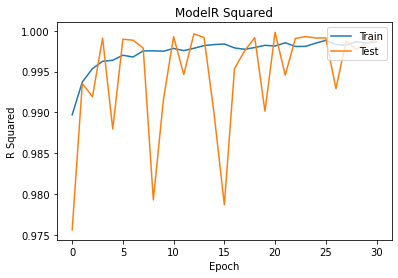

In [17]:
plot_metr(trained_200.history['r_square'][1:], \
          trained_200.history['val_r_square'][1:], 'R Squared')

In [18]:
# serialize model to JSON
model_json_good = final_model_arch.to_json()
with open("results/200epochs_results_greeks/model_200_epochs_greeks.json", "w") as json_file:
    json_file.write(model_json_good)
# serialize weights to HDF5
final_model_arch.save_weights("results/200epochs_results_greeks/model_200_epochs_greeks.h5")
print("Saved model to disk")

Saved model to disk


In [19]:
model_hist_good = final_model_arch.history
train_hist_good = pd.DataFrame(model_hist_good.history)
train_hist_good.to_csv('results/200epochs_results_greeks/train_hist_200_greeks.csv', index=False)